# **Лабораторная работа № 1**

---




## 1. Описание данных
Dataset: "Los Angeles Building and Safety Permits" — это набор данных, который содержит информацию о разрешениях на строительство, выданных в городе Лос-Анджелес. Данные включают различные атрибуты, такие как тип разрешения, его описание, дата подачи, адрес, разрешенная площадь, стоимость и другие параметры. Эти данные можно использовать для анализа тенденций в строительстве, выявления аномальных случаев или прогнозирования будущих разрешений.

## 2. Предложение задачи
Задача, которую можно решить на этом наборе данных:
Предсказание вероятности одобрения разрешения или классификация типов разрешений на основе данных о характеристиках разрешений.

К примеру, мы можем решить задачу классификации, где целью будет классификация разрешений на строительство по типу (например, разрешение на жилое, коммерческое или промышленное строительство). Это позволит городским органам лучше планировать распределение ресурсов или следить за соблюдением норм.

## 3. Выбор алгоритма машинного обучения
Для этой задачи хорошо подойдет алгоритм классификации, так как мы имеем категориальную цель — тип разрешения. Можно выбрать следующие алгоритмы:

Случайный лес (Random Forest) — более сложный, но мощный алгоритм, который хорошо работает с категориальными и числовыми признаками. Он также поможет в случае наличия коллинеарности между признаками.

*   Устойчивость к пропускам и шуму
*   Работа с категориальными и числовыми признаками
*   Интерпретируемость

Ещё, возможно применение следующих алгоритмов:

Логистическая регрессия — для классификации, если признаки линейно разделимы, это простой и интерпретируемый алгоритм.

Градиентный бустинг (XGBoost или LightGBM) — эффективные алгоритмы для сложных задач, где важно учитывать взаимодействия между признаками и минимизировать ошибки.

## 4. Методы оценивания эффективности алгоритма
Для оценки эффективности работы алгоритма будем использовать следующие методы:

Точность (Accuracy) — процент правильно предсказанных классов.
Матрица ошибок (Confusion Matrix) — для более детального анализа, сколько классов было предсказано неправильно.
F1-score — баланс между точностью и полнотой, полезен для случаев с несбалансированными классами.
ROC AUC — для оценки качества классификации в условиях дисбаланса классов.

## 5. Решение

### Шаг 1. Загрузка и первоначальный анализ данных

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cityofLA/los-angeles-building-and-safety-permits")

print("Path to dataset files:", path)

100%|██████████| 164M/164M [00:04<00:00, 37.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11


In [2]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11"

# список файлов
print(os.listdir(dataset_path))


['socrata_metadata_building-and-safety-permit-information.json', 'socrata_metadata_building-and-safety-temporary-special-event-tse-permits.json', 'building-and-safety-temporary-special-event-tse-permits.csv', 'building-and-safety-permit-information.csv']


In [3]:
!mkdir -p /content/dataset
!cp -r /root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11/* /content/dataset/

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from xgboost import XGBClassifier

In [5]:
# Загрузка данных
dataset_path = "/content/dataset/building-and-safety-permit-information.csv"
df = pd.read_csv(dataset_path)

<ipython-input-5-71f5a810eaac>:3: DtypeWarning: Columns (1,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


In [6]:
# Настройка параметров для полного отображения столбцов и без ограничения ширины
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

first_five_rows = df.head()
display(first_five_rows)

,Assessor Book,Assessor Page,Assessor Parcel,Tract,Block,Lot,Reference # (Old Permit #),PCIS Permit #,Status,Status Date,Permit Type,Permit Sub-Type,Permit Category,Project Number,Event Code,Initiating Office,Issue Date,Address Start,Address Fraction Start,Address End,Address Fraction End,Street Direction,Street Name,Street Suffix,Suffix Direction,Unit Range Start,Unit Range End,Zip Code,Work Description,Valuation,Floor Area-L.A. Zoning Code Definition,# of Residential Dwelling Units,# of Accessory Dwelling Units,# of Stories,Contractor's Business Name,Contractor Address,Contractor City,Contractor State,License Type,License #,Principal First Name,Principal Middle Name,Principal Last Name,License Expiration Date,Applicant First Name,Applicant Last Name,Applicant Business Name,Applicant Address 1,Applicant Address 2,Applicant Address 3,Zone,Occupancy,Floor Area-L.A. Building Code Definition,Census Tract,Council District,Latitude/Longitude,Applicant Relationship,Existing Code,Proposed Code,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,4317.0,3.0,***,TR 30210-C,NaN,LT 1,NaN,15044-90000-08405,Permit Finaled,2015-09-10T00:00:00.000,HVAC,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,INTERNET,2015-08-18T00:00:00.000,1823.0,1/2,1823.0,1/2,S,THAYER,AVE,NaN,NaN,NaN,90025.0,NaN,NaN,NaN,NaN,NaN,NaN,CONDITIONED AIRE MECHANICAL & ENGINEERING INC,18650 PARTHENIA STREET,NORTHRIDGE,CA,C20,532440.0,BRETT,MOORE,HOFFER,2016-06-30T00:00:00.000,BRETT,HOFFER,NaN,18650 PARTHENIA ST,NaN,"NORTHRIDGE, CA",R3-1-O,NaN,0.0,2671.00,5.0,"{'longitude': '-118.42628', 'human_address': '...",Net Applicant,NaN,NaN,23443.0,859.0,738.0,9.0,6.0,75.0
1,5005.0,10.0,017,CHESTERFIELD SQUARE,NaN,465,16SL57806,16016-70000-02464,Permit Finaled,2017-08-01T00:00:00.000,Bldg-Alter/Repair,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,SOUTH LA,2016-02-04T00:00:00.000,2122.0,NaN,2122.0,NaN,W,54TH,ST,NaN,NaN,NaN,90062.0,General rehabilitation for single family dwell...,40000.0,NaN,NaN,NaN,NaN,OWNER-BUILDER,NaN,NaN,NaN,NaN,0.0,JAVIER,NaN,TALAMANTES,NaN,JAVIER,TALAMANTES,OWNER-BUILDER,NaN,NaN,NaN,C2-1VL,NaN,NaN,2325.00,8.0,"{'longitude': '-118.31668', 'human_address': '...",Owner-Bldr,1.0,NaN,24027.0,743.0,622.0,7.0,14.0,35.0
2,5154.0,23.0,022,SUN-SET TRACT,D,13,14VN81535,14016-20000-13092,Issued,2014-08-13T00:00:00.000,Bldg-Alter/Repair,Apartment,Plan Check,NaN,NaN,VAN NUYS,2014-08-13T00:00:00.000,415.0,NaN,415.0,NaN,S,BURLINGTON,AVE,NaN,1-30,1-30,90057.0,PHOTOVOLTAIC SOLAR PANELS ON ROOF OF (E) APT BLDG,37000.0,NaN,NaN,NaN,NaN,PERMACITY CONSTRUCTION CORP,5570 W WASHINGTON BLVD,LOS ANGELES,CA,B,827864.0,JONATHAN,SAUL,PORT,2015-11-30T00:00:00.000,LINDA,MARTON,NaN,710 WILSHIRE BLVD,NaN,"SANTA MONICA, CA",R4-1,NaN,NaN,2089.04,1.0,"{'longitude': '-118.26997', 'human_address': '...",Agent for Owner,5.0,NaN,24352.0,563.0,836.0,NaN,11.0,67.0
3,4404.0,30.0,010,TR 12086,NaN,2,NaN,16044-30000-09658,Permit Finaled,2016-08-29T00:00:00.000,HVAC,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,WEST LA,2016-08-22T00:00:00.000,315.0,NaN,315.0,NaN,S,OCEANO,DR,NaN,NaN,NaN,90049.0,NaN,NaN,NaN,NaN,NaN,NaN,E/C HEATING AND AIR CONDITION,26888 CUATRO MILPAS ST,VALENCIA,CA,C20,651051.0,EDY,RUDOLFO,CORDON,2018-07-31T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,RS-1,NaN,0.0,2640.00,11.0,"{'longitude': '-118.4732', 'human_address': '{...",Contractor,NaN,NaN,23680.0,840.0,1219.0,9.0,10.0,NaN
4,2646.0,19.0,011,TR 7158,NaN,11,NaN,17042-90000-31792,Permit Finaled,2017-12-28T00:00:00.000,Plumbing,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,INTERNET,2017-12-26T00:00:00.000,13640.0,NaN,13640.0,NaN,W,PIERCE,ST,NaN,NaN,NaN,91331.0,NaN,NaN,NaN,NaN,NaN,NaN,TITANIUM POWER INC,1545 S LA CIENEGA BLVD,LOS ANGELES,CA,B,989217.0,DENNIS,HARUO,MIYAHIRA,2017-12-31T00:00:00.000,YONI,GHERMEZI,NaN,1545 S LA CIENEGA BLVD,NaN,"LOS ANGELES, CA",R1-1-O,NaN,0.0,1044.03,7.0,"{'longitude': '-118.43002', 'human_address': '...",Net Applicant,NaN,NaN,18907.0,26.0,408.0,NaN,1.0,11.0


In [7]:
# Вывод информации о датасете: типы данных и количество ненулевых значений
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082006 entries, 0 to 1082005
Data columns (total 65 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   Assessor Book                             1080796 non-null  float64
 1   Assessor Page                             1080796 non-null  object 
 2   Assessor Parcel                           1080796 non-null  object 
 3   Tract                                     1077477 non-null  object 
 4   Block                                     210541 non-null   object 
 5   Lot                                       1074314 non-null  object 
 6   Reference # (Old Permit #)                481448 non-null   object 
 7   PCIS Permit #                             1082006 non-null  object 
 8   Status                                    1082006 non-null  object 
 9   Status Date                               1082006 non-null  object 
 10  Permit

Всего столбцов с пропусками: 57

Детализация пропусков:


,Количество пропусков,Процент пропусков
Event Code,1082001,100.00
Suffix Direction,1074843,99.34
Project Number,1071168,99.00
# of Accessory Dwelling Units,1069261,98.82
Address Fraction Start,1067287,98.64
Occupancy,1066524,98.57
Address Fraction End,1056297,97.62
Unit Range End,1055931,97.59
# of Residential Dwelling Units,1032482,95.42
# of Stories,990623,91.55


<ipython-input-8-aced5b8739c7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


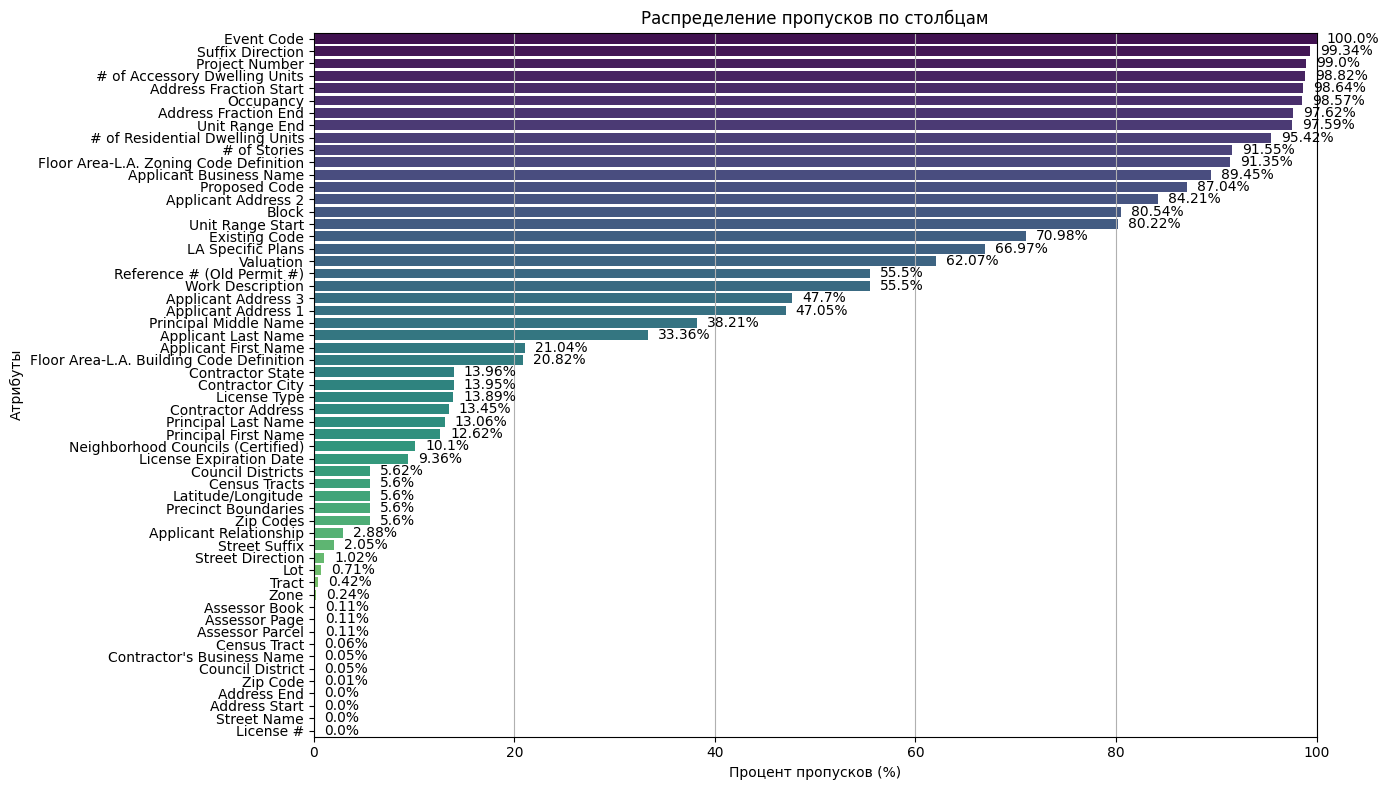

In [8]:
# Рассчитываем количество и процент пропусков
missing_counts = df.isnull().sum()
missing_percent = (missing_counts / len(df)) * 100

# Создаем DataFrame для наглядного отображения
missing_df = pd.DataFrame({
    'Количество пропусков': missing_counts,
    'Процент пропусков': missing_percent.round(2)
}).sort_values('Процент пропусков', ascending=False)

# Фильтруем только столбцы с пропусками
missing_df = missing_df[missing_df['Количество пропусков'] > 0]

print(f"Всего столбцов с пропусками: {len(missing_df)}")
print("\nДетализация пропусков:")
display(missing_df)

# Визуализация
plt.figure(figsize=(14, 8))
sns.barplot(
    x=missing_df['Процент пропусков'],
    y=missing_df.index,
    orient='h',
    palette='viridis'
)
plt.title('Распределение пропусков по столбцам')
plt.xlabel('Процент пропусков (%)')
plt.ylabel('Атрибуты')
plt.xlim(0, 100)
plt.grid(axis='x')

# Добавляем аннотации
for i, (val, name) in enumerate(zip(missing_df['Процент пропусков'], missing_df.index)):
    plt.text(val + 1, i, f'{val}%', va='center')

plt.tight_layout()
plt.show()

# **Лабораторная работа № 2**

## Решение (Продолжение)

### Шаг 2.

In [9]:
# Проверяем уникальные значения в колонке Status
print("Уникальные значения в 'Status':")
print(df['Status'].value_counts(dropna=False))

Уникальные значения в 'Status':
Status
Permit Finaled              711089
Issued                      229729
Permit Expired               54224
CofO Issued                  50343
Permit Closed                14183
Refund Completed              9946
CofC Issued                   3588
CofO in Progress              2937
Refund in Progress            2549
Re-Activate Permit            1850
CofO Corrected                 673
OK for CofC                    366
Permit Withdrawn               169
Permit Revoked                 116
Intent to Revoke               113
OK to Issue CofC                71
No Progress                     21
Insp Scheduled                  10
CofC Corrected                   9
CofO Superseded                  4
Partial Approval                 3
Intent to Correct CofC           3
CofO Revoked                     3
Permit Extended                  2
Not Ready for Inspection         2
Ready to Issue                   1
Intent to Revoke CofC            1
Partial Inspecti

### Создание бинарной целевой переменной
Для нашей задачи классификации нам нужно, чтобы целевая переменная принимала два значения:
**approved** – если статус относится к одобренным, и **rejected** – для остальных.
В данном примере мы считаем статус одобренным, если значение в столбце "Status" входит в список допустимых.

Распределение классов Approval:
Approval
1    994749
0     87257
Name: count, dtype: int64


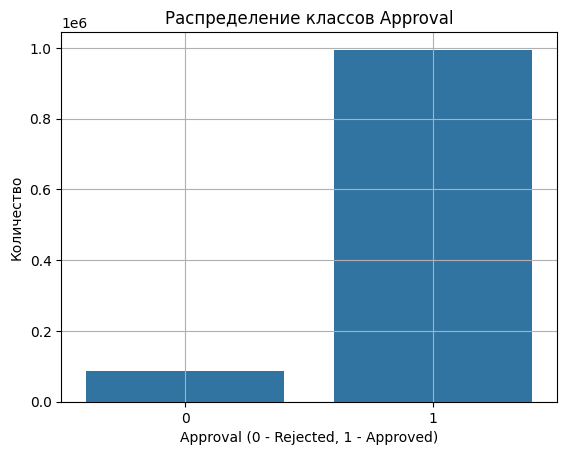

In [12]:
# Определяем список статусов, которые считаем "одобренными"
approved_statuses = ['Permit Finaled', 'Issued', 'CofO Issued', 'CofC Issued']

# Создаем новую колонку 'Approval' - 1 для approved, 0 для rejected
df['Approval'] = df['Status'].apply(lambda x: 1 if x in approved_statuses else 0)

# Проверяем распределение классов
print("Распределение классов Approval:")
print(df['Approval'].value_counts())

# Визуализация распределения классов
sns.countplot(x='Approval', data=data)
plt.title('Распределение классов Approval')
plt.xlabel('Approval (0 - Rejected, 1 - Approved)')
plt.ylabel('Количество')
plt.grid()
plt.show()

### Выбор и предобработка признаков
Для демонстрации выберем небольшой набор признаков. В реальном проекте нужно тщательно исследовать, какие признаки влияют на результат.

В данном примере будем использовать следующие признаки:
- **Permit Type**
- **Permit Sub-Type**
- **Permit Category**
- **Initiating Office**
- **Issue Date** (преобразуем в числовое значение – год выдачи)
- **Valuation**

Остальные признаки можно добавить после анализа их значимости.

,Permit Type,Permit Sub-Type,Permit Category,Initiating Office,Valuation,Approval,Issue Year
0,HVAC,1 or 2 Family Dwelling,No Plan Check,INTERNET,NaN,1,2015
1,Bldg-Alter/Repair,1 or 2 Family Dwelling,No Plan Check,SOUTH LA,40000.0,1,2016
2,Bldg-Alter/Repair,Apartment,Plan Check,VAN NUYS,37000.0,1,2014
3,HVAC,1 or 2 Family Dwelling,No Plan Check,WEST LA,NaN,1,2016
4,Plumbing,1 or 2 Family Dwelling,No Plan Check,INTERNET,NaN,1,2017


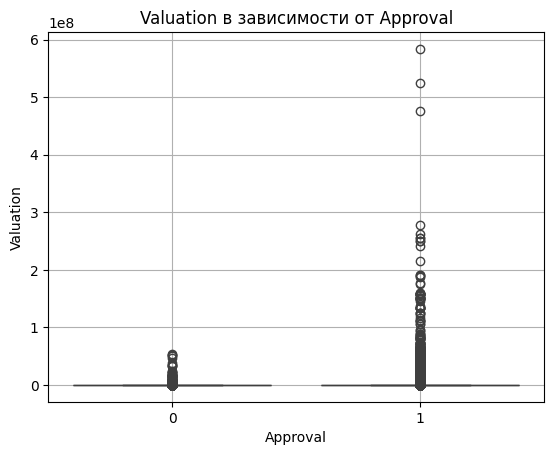

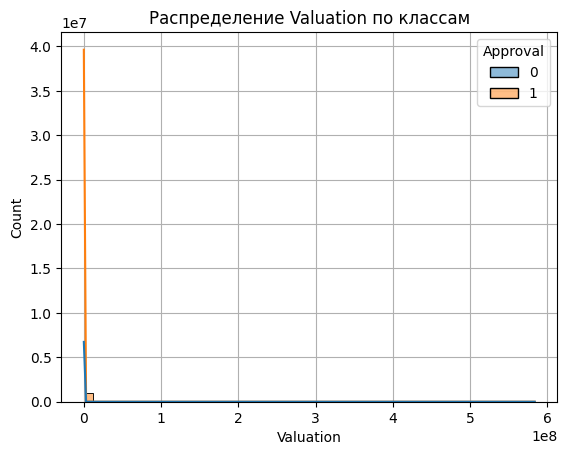

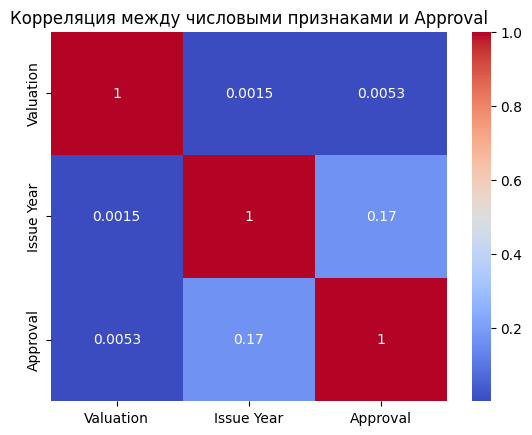

In [13]:
# Выберем подмножество столбцов для модели
selected_columns = ['Permit Type', 'Permit Sub-Type', 'Permit Category',
                    'Initiating Office', 'Issue Date', 'Valuation', 'Approval']

data = df[selected_columns].copy()

# Преобразуем 'Issue Date' в datetime и извлечем год
data['Issue Date'] = pd.to_datetime(data['Issue Date'], errors='coerce')
data['Issue Year'] = data['Issue Date'].dt.year
data.drop('Issue Date', axis=1, inplace=True)

# Посмотрим на данные после преобразования
display(data.head())

# Обработка пропусков: для числовых признаков заполним медианой, для категориальных – модой
num_features = ['Valuation', 'Issue Year']
cat_features = ['Permit Type', 'Permit Sub-Type', 'Permit Category', 'Initiating Office']

# Импутер для числовых данных
num_imputer = SimpleImputer(strategy='median')
data[num_features] = num_imputer.fit_transform(data[num_features])

# Импутер для категориальных данных
cat_imputer = SimpleImputer(strategy='most_frequent')
data[cat_features] = cat_imputer.fit_transform(data[cat_features])

# Boxplot Valuation по классам
sns.boxplot(x='Approval', y='Valuation', data=data)
plt.title('Valuation в зависимости от Approval')
plt.grid()
plt.show()

# Гистограмма Valuation
sns.histplot(data=data, x='Valuation', hue='Approval', bins=50, kde=True)
plt.title('Распределение Valuation по классам')
plt.grid()
plt.show()

# Матрица корреляции
corr = data[['Valuation', 'Issue Year', 'Approval']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Корреляция между числовыми признаками и Approval')
plt.show()

### Кодирование категориальных признаков
Для алгоритмов машинного обучения необходимо перевести категориальные признаки в числовой формат.
В данном примере применим One-Hot Encoding для категориальных признаков.

In [14]:
# Применяем One-Hot Encoding к категориальным признакам
data_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)
display(data_encoded.head())


,Valuation,Approval,Issue Year,Permit Type_Bldg-Alter/Repair,Permit Type_Bldg-Demolition,Permit Type_Bldg-New,Permit Type_Bldg-Relocation,Permit Type_Electrical,Permit Type_Elevator,Permit Type_Fire Sprinkler,Permit Type_Grading,Permit Type_HVAC,Permit Type_Nonbldg-Addition,Permit Type_Nonbldg-Alter/Repair,Permit Type_Nonbldg-Demolition,Permit Type_Nonbldg-New,Permit Type_Plumbing,Permit Type_Pressure Vessel,Permit Type_Sign,Permit Type_Swimming-Pool/Spa,Permit Sub-Type_Apartment,Permit Sub-Type_Commercial,Permit Sub-Type_Offsite,Permit Sub-Type_Onsite,Permit Sub-Type_Public Safety Only,Permit Sub-Type_Special Equipment,Permit Category_Plan Check,Initiating Office_INTERNET,Initiating Office_METRO,Initiating Office_SANPEDRO,Initiating Office_SOUTH LA,Initiating Office_VAN NUYS,Initiating Office_WEST LA
0,8000.0,1,2015.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,40000.0,1,2016.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
2,37000.0,1,2014.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False
3,8000.0,1,2016.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,8000.0,1,2017.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


### Разбиение на обучающую и тестовую выборки

In [15]:
# Определяем признаки (X) и целевую переменную (y)
X = data_encoded.drop('Approval', axis=1)
y = data_encoded['Approval']

# Разбиваем данные в пропорции 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)


Размер обучающей выборки: (865604, 32)
Размер тестовой выборки: (216402, 32)


### Обучение модели RandomForestClassifier
Настроим и обучим модель случайного леса для классификации.
Оценим качество модели с помощью стандартных метрик.

Random Forest Classifier:
Accuracy: 0.9210035027402704
Precision: 0.9250918644986956
Recall: 0.9946117385687934
F1-score: 0.9585930101028696

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.08      0.14     17451
           1       0.93      0.99      0.96    198951

    accuracy                           0.92    216402
   macro avg       0.75      0.54      0.55    216402
weighted avg       0.90      0.92      0.89    216402



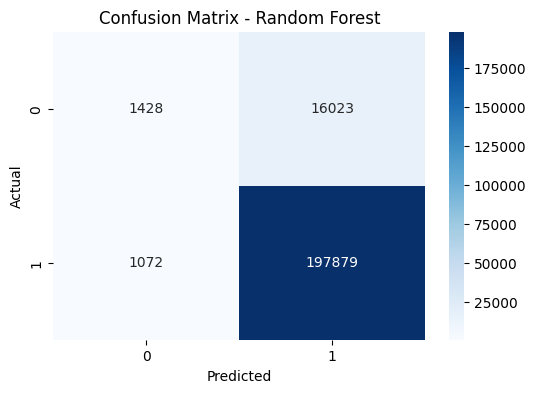

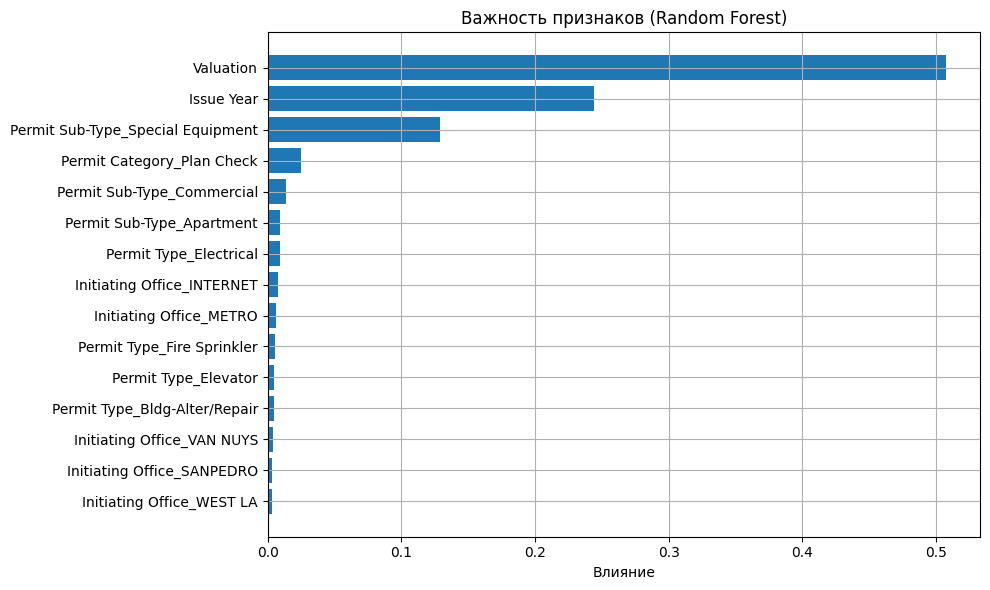

In [16]:
# Инициализируем модель случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Обучаем модель
rf_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # вероятности для класса 1

# Оценка модели
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Матрица ошибок
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Важность признаков
importances = rf_model.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[-15:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Влияние')
plt.tight_layout()
plt.grid()
plt.show()

### Обучение модели XGBClassifier
В качестве альтернативного алгоритма попробуем XGBoost. Также оценим его качество.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:27:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classifier:
Accuracy: 0.9217844567055757
Precision: 0.9223690255753407
Recall: 0.9990047800714749
F1-score: 0.9591585591846189

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.04      0.08     17451
           1       0.92      1.00      0.96    198951

    accuracy                           0.92    216402
   macro avg       0.85      0.52      0.52    216402
weighted avg       0.91      0.92      0.89    216402



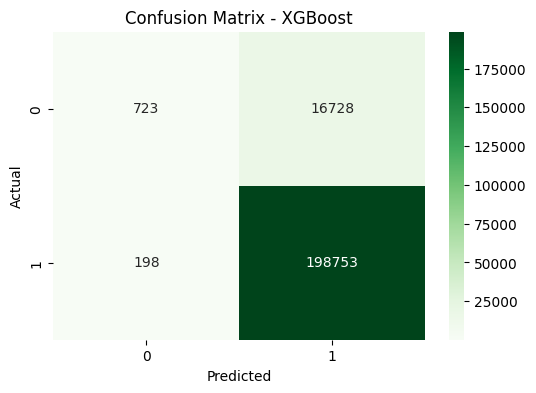

In [17]:
# Инициализируем модель XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Обучаем модель
xgb_model.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Оценка модели
print("XGBoost Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Precision:", precision_score(y_test, y_pred_xgb))
print("Recall:", recall_score(y_test, y_pred_xgb))
print("F1-score:", f1_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

# Матрица ошибок
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### ROC-кривая и AUC

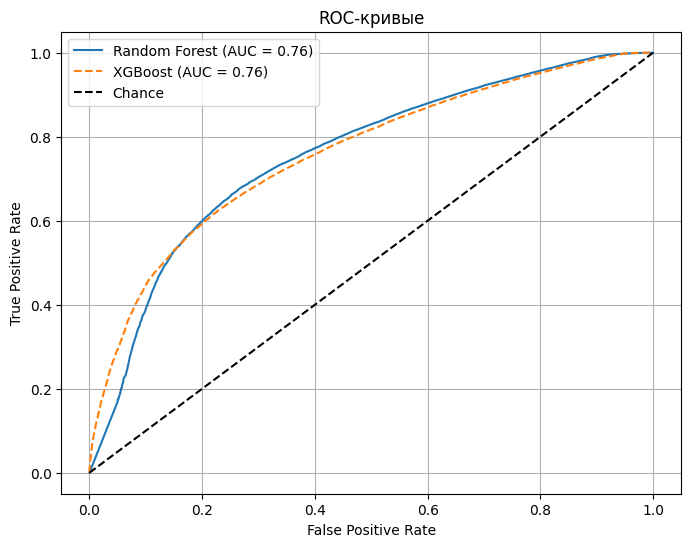

In [18]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title('ROC-кривые')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

### Сравнение моделей и выводы
В данном блоке приведите сравнение результатов моделей RandomForestClassifier и XGBClassifier.

**Замечания для отчёта:**
- Если одна из моделей показывает более высокие метрики (например, F1-score, Precision или Recall), следует сделать акцент на ней.
- Если одна из моделей демонстрирует переобучение или менее стабильные результаты, необходимо указать это в отчёте.

Пример текста:

> "В ходе экспериментов модель RandomForestClassifier показала лучшие результаты по таким метрикам, как F1-score и точность, по сравнению с XGBClassifier. Это свидетельствует о том, что алгоритм случайного леса более стабилен для данной задачи, и, соответственно, мы остановились на нем как на основном алгоритме для предсказания вероятности одобрения."

### Кросс-валидация для дополнительной оценки стабильности модели



In [19]:
# Проводим кросс-валидацию для RandomForestClassifier
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5, scoring='f1')
print("F1-scores (Random Forest) по кросс-валидации:", cv_scores_rf)
print("Средний F1-score:", np.mean(cv_scores_rf))

# Аналогичная оценка для XGBClassifier
cv_scores_xgb = cross_val_score(xgb_model, X, y, cv=5, scoring='f1')
print("\nF1-scores (XGBoost) по кросс-валидации:", cv_scores_xgb)
print("Средний F1-score:", np.mean(cv_scores_xgb))

# Подбор гиперпараметров для XGBoost
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.3]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                    param_grid, cv=3, scoring='f1', verbose=1, n_jobs=-1)

grid.fit(X_train, y_train)

print("Лучшие параметры:", grid.best_params_)
print("Лучший F1-score:", grid.best_score_)

best_xgb = grid.best_estimator_

F1-scores (Random Forest) по кросс-валидации: [0.95875573 0.9578901  0.95769932 0.95772627 0.95618598]
Средний F1-score: 0.957651480823988


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:39:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:39:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:39:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:40:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e


F1-scores (XGBoost) по кросс-валидации: [0.95906396 0.95928019 0.95901002 0.95894311 0.95887449]
Средний F1-score: 0.9590343542221987
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:43:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Лучшие параметры: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100}
Лучший F1-score: 0.9590301984602281


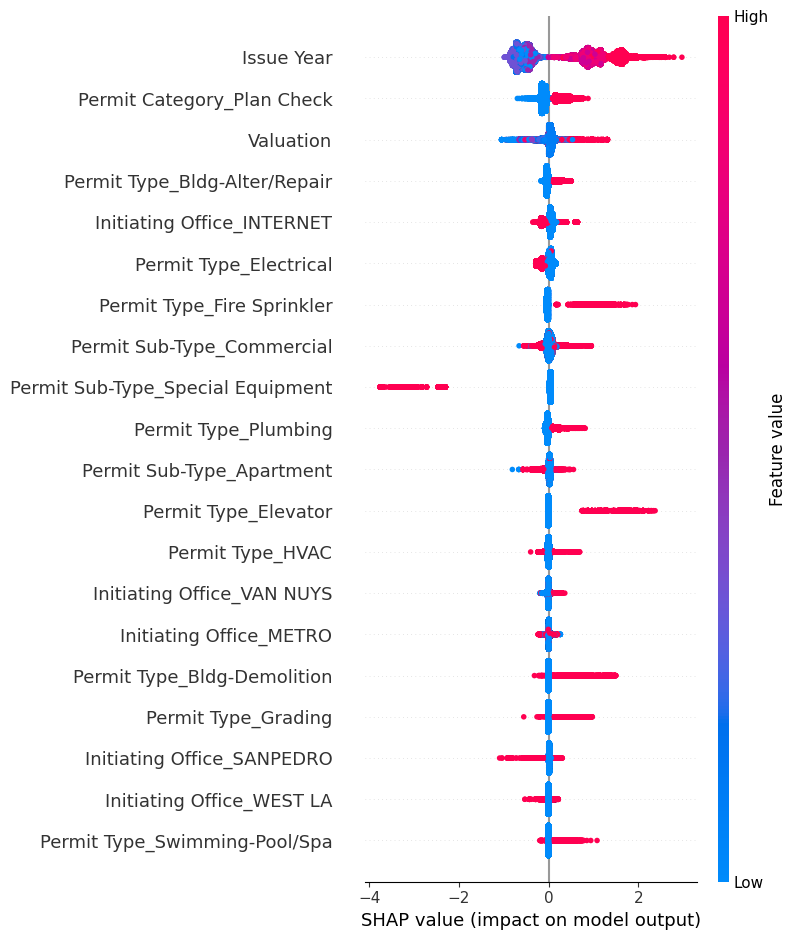

In [20]:
# SHAP-анализ (интерпретация)
import shap

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

## Вывод
В данном ноутбуке мы:

- Создали бинарную целевую переменную **Approval** на основе столбца **Status**.
- Выбрали и предобработали признаки, включая преобразование даты и обработку пропусков.
- Применили One-Hot Encoding для категориальных признаков.
- Построили и оценили две модели: **RandomForestClassifier** и **XGBClassifier**.
- Провели сравнение моделей и кросс-валидацию для оценки стабильности.

На основании полученных результатов можно сделать вывод о том, что модель [например, RandomForestClassifier] показывает более стабильные и высокие метрики по сравнению с XGBoost, что позволяет использовать её для прогнозирования вероятности одобрения разрешения.

# **Лабораторная работа № 3**

## Параллельный режим
Позволяет:

1. ускорить обучение нескольких моделей одновременно,

2. использовать все доступные ядра процессора,

3. повысить общую эффективность при экспериментах с несколькими алгоритмами.



## Решение

In [ ]:
from joblib import Parallel, delayed
import multiprocessing
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# Функция для обучения и оценки модели
def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "model": model.__class__.__name__,
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }

# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Определяем модели
models = [
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
]

# Количество ядер процессора
num_cores = multiprocessing.cpu_count()

# Запускаем обучение моделей в параллельном режиме
results = Parallel(n_jobs=num_cores)(delayed(train_and_evaluate_model)(model, X_train, X_test, y_train, y_test) for model in models)

# Вывод результатов
for res in results:
    print(f"Модель: {res['model']}")
    print(f"Accuracy: {res['accuracy']:.4f}")
    print(f"Precision: {res['precision']:.4f}")
    print(f"Recall: {res['recall']:.4f}")
    print(f"F1-score: {res['f1_score']:.4f}")
    print('-' * 40)

Модель: RandomForestClassifier
Accuracy: 0.9210
Precision: 0.9251
Recall: 0.9946
F1-score: 0.9586
----------------------------------------
Модель: XGBClassifier
Accuracy: 0.9218
Precision: 0.9224
Recall: 0.9990
F1-score: 0.9592
----------------------------------------


## Вывод